# TUTORIAL 
## Analisis Territorial

In [58]:
import matplotlib.pyplot as plt 
import pandas as pd 
import numpy as np
import difflib
import os

from unidecode import unidecode
pd.options.mode.chained_assignment = None

In [59]:
def to_unicode(column):
    if isinstance(column, list):
        column = pd.Series(column)
        column = column.apply(lambda x: unidecode(str(x)).lower())
        return column.values[0]
    if isinstance(column, pd.Series):
        column = column.apply(lambda x: unidecode(str(x)).lower())
        return column
    if isinstance(column, pd.DataFrame):
        for c in column.columns:
             column[c] = column[c].apply(lambda x: unidecode(str(x).lower()))
        return column
    if isinstance(column, str):
        column = unidecode(column).lower()
                  
    return column

Descarga aqui la base de datos en formato `.csv`. Una vez tengamos las tablas en nuestro directorio local, cargaremos la matriz de distancias desde la [Direccion de Vialidad](http://www.vialidad.cl/Biblioteca/ChileOct2018.7z)

In [60]:
comunas  = pd.read_csv('./data/comunas.csv')
# Saltamos las tres primeras filas porque estan vacias
distancias = pd.read_excel('./data/Matriz-ChileOct2018.xlsx', skiprows=3)

Primero que todo, debemos mapear el nombre de las ciudades (desde la matriz de distancias) a su respectivo `comuna_id`.

In [61]:
# Estandarizamos los nombres de las comunas
distancias.columns = [x.strip() for x in distancias.columns]
distancias['Distancias aproximadas por Chile'] = to_unicode(distancias['Distancias aproximadas por Chile'])
distancias['Distancias aproximadas por Chile'] = [x.strip() for x in distancias['Distancias aproximadas por Chile']]

Borramos espacio en blanco de cada columna

In [62]:
dist_comuna_list = distancias['Distancias aproximadas por Chile'].values
distancias_revised = []
for i, x in comunas.iterrows():
    match = difflib.get_close_matches(to_unicode(x['name']), dist_comuna_list, 1, 0.9)
    try:
        result = distancias[distancias['Distancias aproximadas por Chile'] == match[0]]
        result['comuna_id'] = x['id']
        distancias_revised.append(result)
    except:
        # NO hay informacion de distancias para esa comuna
        continue

En la funcion anterior utilizamos `difflib.get_close_matches()` con un 90% de similitud para evitar eliminar comunas que, teniendo el mismo nombre, fueron escritas de manera distinta 

In [63]:
# eliminamos la primera columna i.e., la columna con el nombre de la comuna
dist_enc = pd.concat(distancias_revised).iloc[:, 1:]

Guardamos el nuevo `.csv` para usos futuros

In [64]:
dist_enc.to_csv('./data/distancias_comunas.csv', index=False)

Ahora tenemos nuestra matriz de distancias asociada al id de las comunas en nuestra base de datos.

### K Vecinos mas cercanos  

Para calcular los k-vecinos mas cercanos utilizaremos la matriz de distancia. En particular, filtraremos la comuna objetivo, luego ordenaremos las distancias hacia las otras ciudades desde menor a mayor. 

In [65]:
def get_neighborhood(id_comuna, dist_matrix, K=3):
    # Filtrar por id_comuna
    singular_dist = dist_matrix[dist_matrix['comuna_id'] == id_comuna]
    # Eliminar comunas sin distancia
    singular_dist = singular_dist.dropna(axis=1)
    # Extraemos solo las distancias (recordar que la ultima columna corresponde a comuna_id)
    singular_dist = singular_dist.iloc[:,:-1]

    distancias = singular_dist.values[0]
    indices = np.argsort(distancias)
    
    closest = singular_dist.columns.values[indices][:K+1]
    dist = distancias[indices][:K+1]
    closest_id = [comunas[to_unicode(comunas['name']) == to_unicode(x)]['id'].values[0] for x in closest]
    return closest, closest_id, dist

Como ejemplo utilizaremos `Lota`

In [66]:
singular_id = comunas[comunas['name'] == 'Lota']['id'].values[0]
singular_id

8106

In [67]:
closest_nombres, closest_id, distancia = get_neighborhood(singular_id, dist_enc)

En nuestro esquema de base de datos, tenemos dos tablas principales: `dialogos.csv` y `individuals.csv` las cuales corresponden a las mesas de discusion y encuestas individuales respectivamente

In [68]:
dialogos = pd.read_csv('./data/dialogues.csv')
individuales = pd.read_csv('./data/individuals.csv')

Debemos extraer los `id` asociados a las **mesas de discusion** o **individuos** que se encuentren en la comuna objetivo. En este ejemplo utilizaremos las encuestas `individuales`

In [69]:
comuna_frame = individuales[individuales['comuna_id'].isin(closest_id)]
comuna_frame.sample(3)

,id,date,age,comuna_id,level,age_range,online
13212,b8a7bc5d4f27f4f099ad3c232ac3f6ba,29-11-2019,44.0,8108,Universitaria completa.,30-45,True
11763,f15b078789fc8dd20a7d7648797d6e45,25-01-2020,45.0,8108,Universitaria completa.,45-60,True
12605,f19898f05bc58aa7dc9e8240ebe094a2,26-12-2019,22.0,8108,Media completa. Técnica incompleta.,15-30,True


### Emociones mas frecuentes en la comuna y su vecindad 

Primero debemos abrir el `.csv` asociado a las emociones

In [70]:
emociones = pd.read_csv('./data/emotions.csv', low_memory=False)

In [71]:
emociones.sample(1)

,id,diag_id,ind_id,name,name_tokens,macro,exp,exp_tokens,is_online
67736,67736,NaN,3910780,preocupacion,['preocupacion'],Miedo,NaN,NaN,False


Utilizaremos la columna `macro`, la cual corresponde a la categorizacion hecha en la etapa de Sistematizacion

In [72]:
individuos_comuna = comuna_frame.groupby('comuna_id')

In [73]:
nombre_comunas = []
valores = []
for i, frame in individuos_comuna:
    subframe = emociones[emociones['ind_id'].isin(frame['id'])]['macro']
    moda = subframe.mode().values[0]
    nombre_comuna = comunas[comunas['id'] == frame['comuna_id'].values[0]]['name'].values[0]
    nombre_comunas.append(nombre_comuna)
    valores.append(moda)
    
df_res = pd.DataFrame()
df_res['comuna'] = nombre_comunas
df_res['moda'] = valores

In [74]:
df_res

,comuna,moda
0,Coronel,Miedo
1,Lota,Repulsión
2,San Pedro De La Paz,Miedo
3,Arauco,Alegría


# Resumen

Ahora juntaremos todo en una funcion que, **dada una comuna y un conjunto de encuestas**, nos entregue `emocion`, `contribucion`, y `necesidades`. Para esto **es necesario tener todos los archivos de la base de datos** y el archivo `distancias_comunas.csv` que generamos al principio del tutorial.

En esta funcion no utilizaremos la `moda` ya que nos quita informacion. En cambio, utilizaremos los `num_top` mas frecuentes de cada categoria. Por defecto `num_top = 1` lo cual es equivalente a la moda.

In [75]:
def get_top(column_macro):
    return column_macro.value_counts(normalize=True).sort_values(ascending=False)

In [76]:
def get_territorial(comuna_id, individuales_frame=None, dialogos_frame=None, num_vecinos=3, num_top=1, bd_dir='./data'):
    '''
    Esta funcion recibe el id de una comuna y devuelve las emociones necesidades y contribuciones 
    mas frecuentes para ella y sus K vecinos mas cercanos.
    '''
    comunas  = pd.read_csv(os.path.join(bd_dir, 'comunas.csv'))
    # Saltamos las tres primeras filas porque estan vacias
    dist_enc = pd.read_csv(os.path.join(bd_dir, 'distancias_comunas.csv'))
    
    closest_nombres, closest_id, closest_dist = get_neighborhood(comuna_id, dist_enc, K=num_vecinos)
    
    if individuales_frame is not None:
        comuna_frame = individuales_frame[individuales_frame['comuna_id'].isin(closest_id)]
        columna_id = 'ind_id'
        
    if dialogos_frame is not None:
        comuna_frame = dialogos_frame[dialogos_frame['comuna_id'].isin(closest_id)]
        columna_id = 'diag_id'
    
    emociones              = pd.read_csv(os.path.join(bd_dir, 'emotions.csv'), low_memory=False)
    contribuciones         = pd.read_csv(os.path.join(bd_dir, 'contributions.csv'), low_memory=False)
    necesidades_pais       = pd.read_csv(os.path.join(bd_dir, 'country_needs.csv'), low_memory=False)
    necesidades_personales = pd.read_csv(os.path.join(bd_dir, 'personal_needs.csv'), low_memory=False)
    # Arreglar los id
    emociones['diag_id']                = to_unicode(emociones['diag_id'])
    contribuciones['diag_id']           = to_unicode(contribuciones['diag_id'])
    necesidades_pais['diag_id']         = to_unicode(necesidades_pais['diag_id'])
    necesidades_personales['diag_id']   = to_unicode(necesidades_personales['diag_id'])
    
    group_comuna = comuna_frame.groupby('comuna_id')
    
    nombre_comunas = []
    valores_emo = []
    valores_con = []
    valores_cne = []
    valores_pne = []
    valores_dis = []
    
    test = []
    for i, frame in group_comuna:

        subframe_emo = emociones[emociones[columna_id].isin(frame['id'])]['macro']
        subframe_con = contribuciones[contribuciones[columna_id].isin(frame['id'])]['macro']
        subframe_cne = necesidades_pais[necesidades_pais[columna_id].isin(frame['id'])]['macro']
        subframe_pne = necesidades_personales[necesidades_personales[columna_id].isin(frame['id'])]['macro']
              
        top_emo = get_top(subframe_emo)
        top_con = get_top(subframe_con)
        top_cne = get_top(subframe_cne)
        top_pne = get_top(subframe_pne)
        
        valores_emo.append(top_emo.index.values[0:num_top])
        valores_con.append(top_con.index.values[0:num_top])        
        valores_cne.append(top_cne.index.values[0:num_top])
        valores_pne.append(top_pne.index.values[0:num_top])

        nombre_comuna = comunas[comunas['id'] == frame['comuna_id'].values[0]]['name'].values[0]
        nombre_comunas.append(nombre_comuna)

        # distancia
        j = closest_id.index(frame['comuna_id'].values[0])
        subframe_dis = closest_dist[j]
        valores_dis.append(subframe_dis)
                
        
    df_res = pd.DataFrame()
    df_res['comuna'] = nombre_comunas
    df_res['emocion'] = valores_emo
    df_res['contribucion'] = valores_con
    df_res['necesidad pais'] = valores_cne
    df_res['necesidad personal/familiar'] = valores_pne
    df_res['distancia (km)'] = valores_dis
    return df_res.sort_values('distancia (km)')

In [77]:
territorial_dialogos = get_territorial(singular_id, dialogos_frame=dialogos, num_vecinos=3, num_top=2)

In [78]:
territorial_dialogos

,comuna,emocion,contribucion,necesidad pais,necesidad personal/familiar,distancia (km)
1,Lota,"[Miedo, Tristeza]","[Reciprocidad-Redes, Participacion]","[NR, pensiones]","[salud, familia]",0.000000
0,Coronel,"[Miedo, Enojo]","[Reciprocidad-Redes, Participacion]","[NR, pensiones]","[educacion, escacez hidrica]",8.136202
2,San Pedro De La Paz,"[Miedo, Tristeza]","[Participacion, Reciprocidad-Redes]","[NR, pensiones]","[vivienda, familia]",30.441332
3,Arauco,"[Miedo, Tristeza]","[Reciprocidad-Redes, Participacion]","[NR, pensiones]","[escacez hidrica, vivienda]",33.614461


In [79]:
territorial_individuos = get_territorial(singular_id, individuales_frame=individuales, num_vecinos=5, num_top=3)

In [80]:
territorial_individuos

,comuna,emocion,contribucion,necesidad pais,necesidad personal/familiar,distancia (km)
3,Lota,[Repulsión],[Reciprocidad-Redes],[vivienda y subsistencia],[familia],0.000000
1,Coronel,"[Miedo, Enojo, Alegría]","[Participacion, Reciprocidad-Redes, Confianza ...","[pensiones, NR, vivienda y subsistencia]","[sueldos y pensiones, familia, educacion]",8.136202
4,San Pedro De La Paz,"[Miedo, Enojo, Tristeza]","[Reciprocidad-Redes, Trabajo, Participacion]","[NR, pensiones, educacion]","[familia, NR, salud]",30.441332
5,Arauco,"[Tristeza, Alegría]",[Reciprocidad-Redes],"[cambios politicos, educacion]",[vivienda],33.614461
0,Concepción,"[Miedo, Enojo, Alegría]","[Reciprocidad-Redes, Participacion, Trabajo]","[NR, pensiones, educacion]","[familia, NR, salud]",36.824732
2,Chiguayante,"[Miedo, Enojo, Alegría]","[Reciprocidad-Redes, Confianza en las instituc...","[NR, educacion, pensiones]","[familia, sueldos y pensiones]",45.132142


# Visualizando por Region

In [81]:
def get_territorial_regiones(individuales_frame=None, dialogos_frame=None, num_top=2, bd_dir='./data'):
    
    emociones              = pd.read_csv(os.path.join(bd_dir, 'emotions.csv'), low_memory=False)
    contribuciones         = pd.read_csv(os.path.join(bd_dir, 'contributions.csv'), low_memory=False)
    necesidades_pais       = pd.read_csv(os.path.join(bd_dir, 'country_needs.csv'), low_memory=False)
    necesidades_personales = pd.read_csv(os.path.join(bd_dir, 'personal_needs.csv'), low_memory=False)
    # Arreglar los id
    emociones['diag_id']                = to_unicode(emociones['diag_id'])
    contribuciones['diag_id']           = to_unicode(contribuciones['diag_id'])
    necesidades_pais['diag_id']         = to_unicode(necesidades_pais['diag_id'])
    necesidades_personales['diag_id']   = to_unicode(necesidades_personales['diag_id'])

    regiones = pd.read_csv('./data/regions.csv')
    
    # Por cada region extraemos las comunas
    region_nombres = []
    valores_emo, scores_emo = [], []
    valores_con, scores_con = [], []
    valores_cne, scores_cne = [], []
    valores_pne, scores_pne = [], []
    
    for i, reg in regiones.iterrows():
        nombre_region = reg['name']
        comunas_region = comunas[comunas['region_iso'] == reg['iso']]

        if individuales_frame is not None:
            comuna_frame = individuales_frame[individuales_frame['comuna_id'].isin(comunas_region['id'])]
            columna_id = 'ind_id'

        if dialogos_frame is not None:
            comuna_frame = dialogos_frame[dialogos_frame['comuna_id'].isin(comunas_region['id'])]
            columna_id = 'diag_id'
        
        subframe_emo = emociones[emociones[columna_id].isin(comuna_frame['id'])]['macro']
        subframe_con = contribuciones[contribuciones[columna_id].isin(comuna_frame['id'])]['macro']
        subframe_cne = necesidades_pais[necesidades_pais[columna_id].isin(comuna_frame['id'])]['macro']
        subframe_pne = necesidades_personales[necesidades_personales[columna_id].isin(comuna_frame['id'])]['macro']

        region_nombres.append(nombre_region)
        
        top_emo = get_top(subframe_emo)
        top_con = get_top(subframe_con)
        top_cne = get_top(subframe_cne)
        top_pne = get_top(subframe_pne)
        
        valores_emo.append(top_emo.index.values[0:num_top])
        valores_con.append(top_con.index.values[0:num_top])
#         valores_cne.append(top_cne.index.values[0:num_top])
#         valores_pne.append(top_pne.index.values[0:num_top])

        scores_emo.append(top_emo.values[0:num_top])
        scores_con.append(top_con.values[0:num_top])
#         scores_cne.append(top_cne.values[0:num_top])
#         scores_pne.append(top_pne.values[0:num_top])


    df_res = pd.DataFrame()
    df_res['region'] = region_nombres
    df_res['emocion'] = valores_emo
    df_res['emo_scores'] = scores_emo
    df_res['contribucion'] = valores_con
    df_res['con_scores'] = scores_con
#     df_res['necesidad pais'] = valores_cne
#     df_res['necesidad personal/familiar'] = valores_pne

    return df_res

In [82]:
regiones_ind = get_territorial_regiones(individuales_frame=individuales, num_top=3)
regiones_ind.head(2)

,region,emocion,emo_scores,contribucion,con_scores
0,Tarapacá,"[Miedo, Enojo, Alegría]","[0.30212014134275617, 0.25618374558303886, 0.2...","[Reciprocidad-Redes, Trabajo, Confianza en las...","[0.2916666666666667, 0.17708333333333334, 0.13..."
1,Antofagasta,"[Miedo, Alegría, Tristeza]","[0.4326241134751773, 0.2198581560283688, 0.148...","[Reciprocidad-Redes, Participacion, Trabajo]","[0.4146341463414634, 0.14634146341463414, 0.12..."


In [83]:
regiones_diag = get_territorial_regiones(dialogos_frame=dialogos, num_top=3)
regiones_diag.head(2)

,region,emocion,emo_scores,contribucion,con_scores
0,Tarapacá,"[Miedo, Enojo, Tristeza]","[0.3963254593175853, 0.1889763779527559, 0.181...","[Reciprocidad-Redes, Participacion, Educación ...","[0.2600286532951289, 0.2141833810888252, 0.113..."
1,Antofagasta,"[Miedo, Enojo, Tristeza]","[0.4165477888730385, 0.19686162624821682, 0.19...","[Reciprocidad-Redes, Participacion, Educación ...","[0.25222363405336723, 0.20012706480304956, 0.1..."


`emo_scores` es la frecuencia normalizada de la categoria 

# Visualizando 

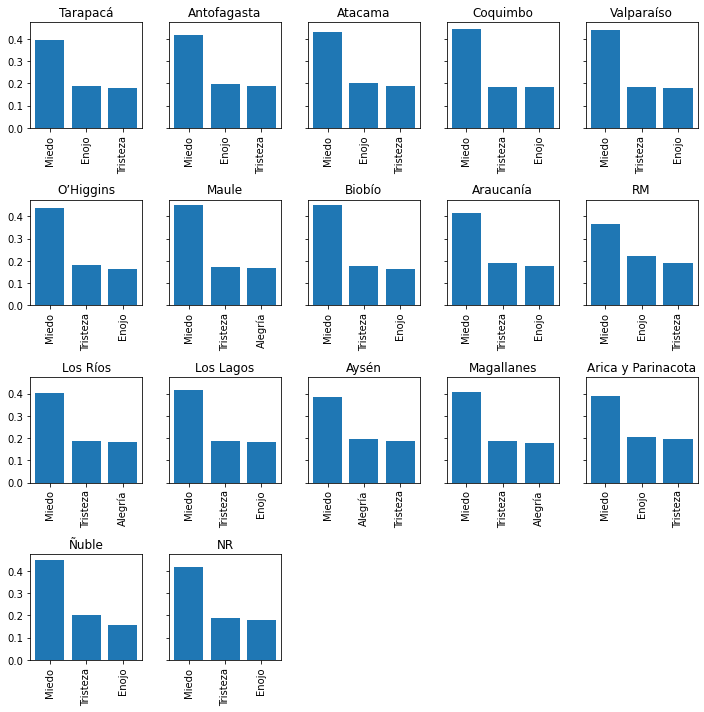

In [84]:
import math
n_cols = 5
n_rows = math.ceil(regiones_diag.shape[0]/n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(10,10), sharey=True)

for i, frame in regiones_diag.iterrows():
    row = i//n_cols
    col = i%n_cols
    
    emo = list(frame['emocion'])
    scores = list(frame['emo_scores'])
    x = range(len(emo))
    
    axes[row][col].bar(x, scores)
    axes[row][col].set_xticks(x)
    axes[row][col].set_xticklabels(emo, rotation=90)
    axes[row][col].set_title(frame['region'])

fig.tight_layout()

for k in range(i+1, n_cols*n_rows):
    row = k//n_cols
    col = k%n_cols
    fig.delaxes(axes[row][col])